In [61]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt

In [7]:
boston=pd.read_csv("boston_house.csv")
col=boston.columns.str.upper()
boston.columns=col
boston.rename(columns={"MEDV":"price"},inplace=True)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


# check lienearity assumptions

### inital setup


#### for checking linearity I've got help fron this site https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/ and https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression/notebook and other sites!!!

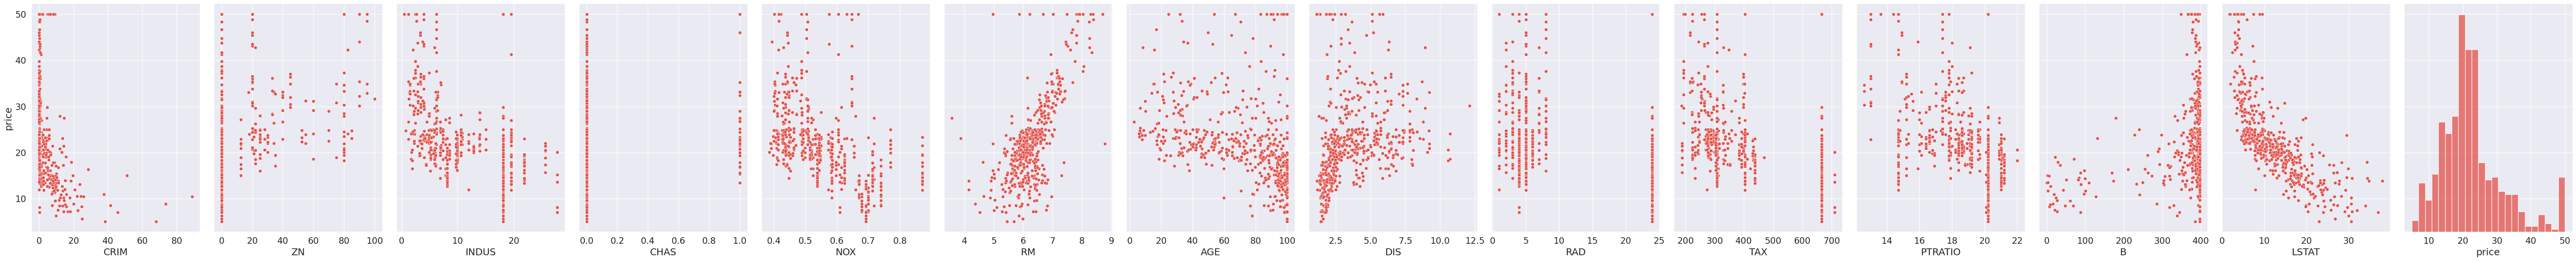

In [8]:
sns.pairplot(boston,y_vars="price",size=7, aspect=0.7)


In [10]:
from sklearn.linear_model import LinearRegression
x=boston.drop("price",axis=1)
y=boston.price
# Fitting the model
boston_model = LinearRegression()
boston_model.fit(x, y)

# Returning the R^2 for the model
boston_r2 = boston_model.score(x,y)
print('R^2: {0}'.format(boston_r2))


R^2: 0.7406426641094094


In [13]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results


### linearity

This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). This also assumes that the predictors are additive.

<b>Why it can happen</b>: There may not just be a linear relationship among the data. Modeling is about trying to estimate a function that explains a process, and linear regression would not be a fitting estimator (pun intended) if there is no linear relationship.

<b>What it will affect</b>: The predictions will be extremely inaccurate because our model is underfitting. This is a serious violation that should not be ignored.

<b>How to detect it</b>: If there is only one predictor, this is pretty easy to test with a scatter plot. Most cases aren’t so simple, so we’ll have to modify this by using a scatter plot to see our predicted values versus the actual values (in other words, view the residuals). Ideally, the points should lie on or around a diagonal line on the scatter plot.

<b>How to fix it</b>: Either adding polynomial terms to some of the predictors or applying nonlinear transformations . If those do not work, try adding additional variables to help capture the relationship between the predictors and the label.

In [39]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.
Actual        5.000000
Predicted    -4.281311
Residuals   -15.594474
dtype: float64


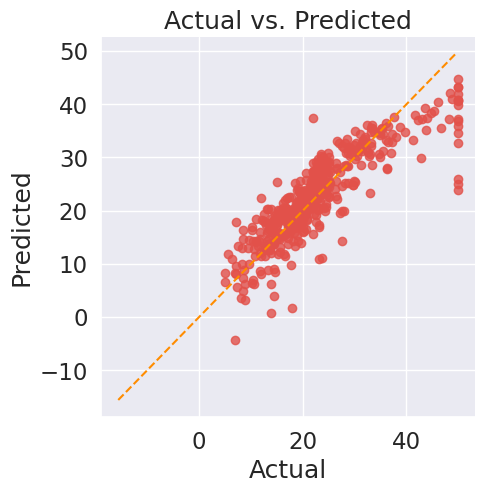

In [40]:
linear_assumption(boston_model,x,y)

In [44]:
df_results = calculate_residuals(boston_model, x, y)
df_results.head()

,Actual,Predicted,Residuals
0,24.0,30.003843,-6.003843
1,21.6,25.025562,-3.425562
2,34.7,30.567597,4.132403
3,33.4,28.607036,4.792964
4,36.2,27.943524,8.256476


<AxesSubplot:xlabel='Predicted', ylabel='Residuals'>

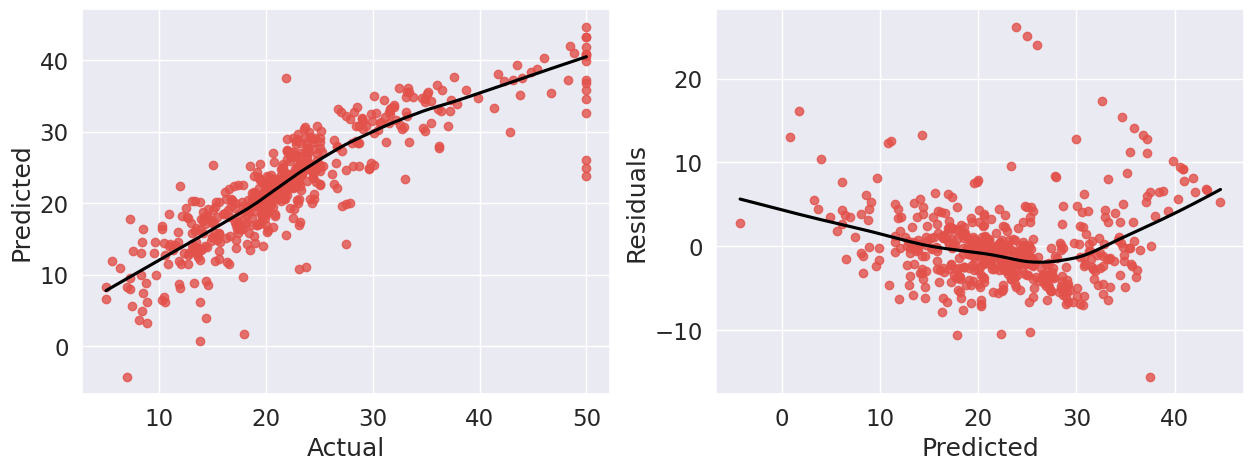

In [50]:
fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.regplot(x=df_results["Actual"],y=df_results["Predicted"],ax=axes[0],order=1,lowess=True,line_kws={'color': 'black'})
sns.regplot(x=df_results["Predicted"],y=df_results["Residuals"],ax=axes[1],lowess=True,line_kws={'color': 'black'})

We can see in this case that there is not a perfect linear relationship. Our predictions are biased towards lower values in both the lower end (around 5-10) and especially at the higher values (above 40).

<h2> Mean of Residuals </h2>
Residuals as we know are the differences between the true value and the predicted value. One of the assumptions of linear regression is that the mean of the residuals should be zero. So let's find out.

In [52]:
mean_residuals=df_results["Residuals"].mean()
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -0.01692217671615214


<h2>Normality of the Error </h2>

More specifically, this assumes that the error terms of the model are normally distributed. Linear regressions other than Ordinary Least Squares (OLS) may also assume normality of the predictors or the label, but that is not the case here.

<b>Why it can happen</b>: This can actually happen if either the predictors or the label are significantly non-normal. Other potential reasons could include the linearity assumption being violated or outliers affecting our model.

<b>What it will affect</b>: A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals.

<b>How to detect it</b>: There are a variety of ways to do so, but we’ll look at both a histogram and the p-value from the Anderson-Darling test for normality.

<b>How to fix it</b>: It depends on the root cause, but there are a few options. Nonlinear transformations of the variables, excluding specific variables (such as long-tailed variables), or removing outliers may solve this problem.

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 8.311128328210816e-25
Residuals are not normally distributed


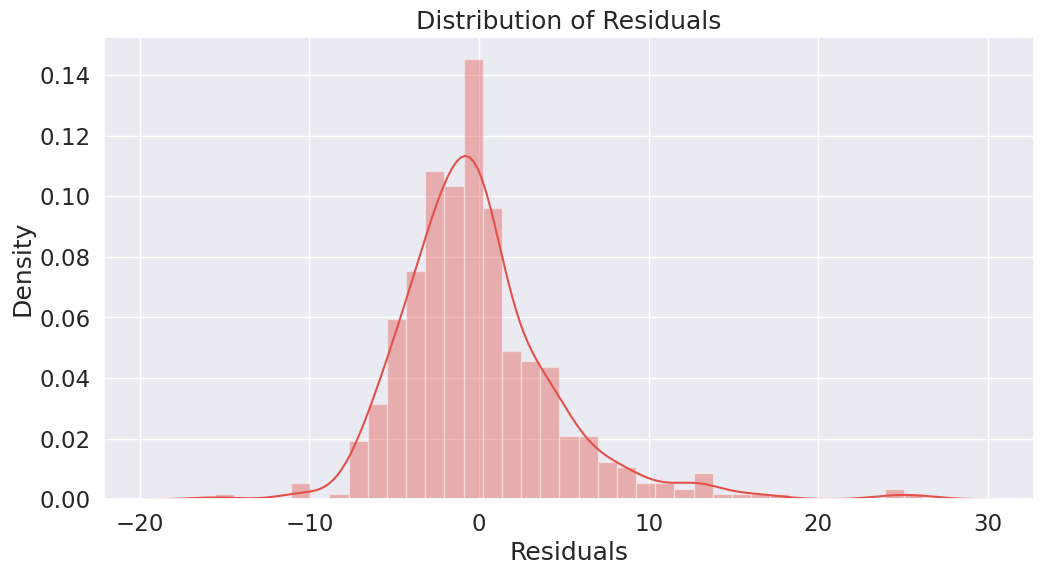


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [54]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

normal_errors_assumption(boston_model, x, y)


### or too simplify

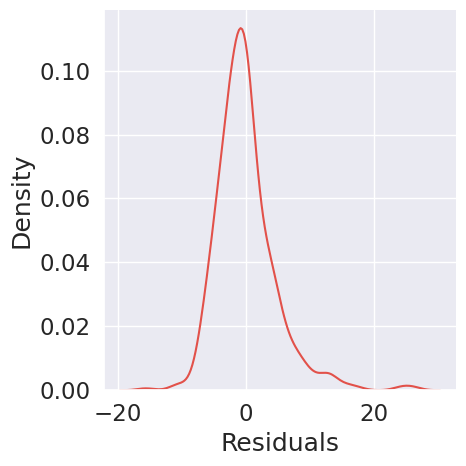

In [56]:
sns.displot(df_results["Residuals"],kind="kde")

#### This isn’t ideal, and we can see that our model is biasing towards under-estimating.

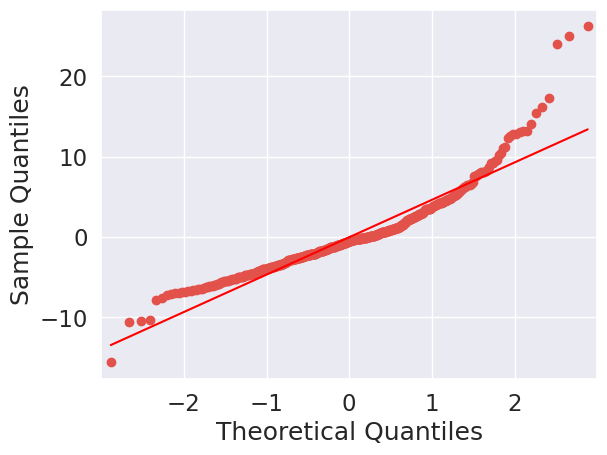

In [88]:
## another  way to check normality

# QQ Plot
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
data=df_results["Residuals"]
# q-q plot
qqplot(data, line='s')
pyplot.show()

##### opppsSS!!

## check normality with normaltest

In [90]:
from scipy.stats import normaltest
# normality test
stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

Statistics=180.097, p=0.000
Sample does not look Gaussian (reject H0)


## check normality with boxplot

<AxesSubplot:xlabel='Residuals'>

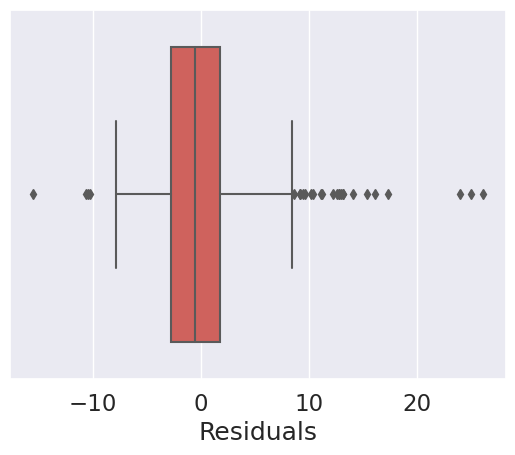

In [93]:
sns.boxplot(x=data)

## Shapiro-Wilk Test

On the other hand, there are many Statistical Tests to check if the distribution of a variable is normal/gaussian

In [94]:
from scipy.stats import shapiro
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

Statistics=0.901, p=0.000
Sample does not look Gaussian (reject H0)


## No Multicollinearity among Predictors


In regression, multicollinearity refers to the extent to which independent variables are correlated. Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity.


<b>Why it can happen </b>: A lot of data is just naturally correlated. For example, if trying to predict a house price with square footage, the number of bedrooms, and the number of bathrooms, we can expect to see correlation between those three variables because bedrooms and bathrooms make up a portion of square footage.

<b>What it will affect</b>: Multicollinearity causes issues with the interpretation of the coefficients. Specifically, you can interpret a coefficient as “an increase of 1 in this predictor results in a change of (coefficient) in the response variable, holding all other predictors constant.” This becomes problematic when multicollinearity is present because we can’t hold correlated predictors constant. Additionally, it increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant.

<b>How to detect it</b>: There are a few ways, but we will use a heatmap of the correlation as a visual aid and examine the variance inflation factor (VIF).

<b>How to fix it</b>: This can be fixed by other removing predictors with a high variance inflation factor (VIF) or performing dimensionality reduction.

In [69]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
   # plt.figure(figsize = (10,10))
    print (boston.corr())
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
multicollinearity_assumption(boston_model, x, y,boston.columns)

Assumption 3: Little to no multicollinearity among predictors
             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
ZN      -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
NOX      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
DIS     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
RAD      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
TAX      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
PTRATIO  0.289946 -0.391679  0.383248 -0.121515

### No Autocorrelation of the Error 

### No Autocorrelation of the Error TermsPermalink

This assumes no autocorrelation of the error terms. Autocorrelation being present typically indicates that we are missing some information that should be captured by the model.

<b>Why it can happen </b>: In a time series scenario, there could be information about the past that we aren’t capturing. In a non-time series scenario, our model could be systematically biased by either under or over predicting in certain conditions. Lastly, this could be a result of a violation of the linearity assumption.

<b>What it will affect</b>: This will impact our model estimates.

<b>How to detect it</b>: We will perform a Durbin-Watson test to determine if either positive or negative correlation is present. Alternatively, you could create plots of residual autocorrelations.

<b>How to fix it</b>: A simple fix of adding lag variables can fix this problem. Alternatively, interaction terms, additional variables, or additional transformations may fix this.

In [79]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')
autocorrelation_assumption(boston_model,x,y)


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.0715916506006846
Signs of positive autocorrelation 

Assumption not satisfied


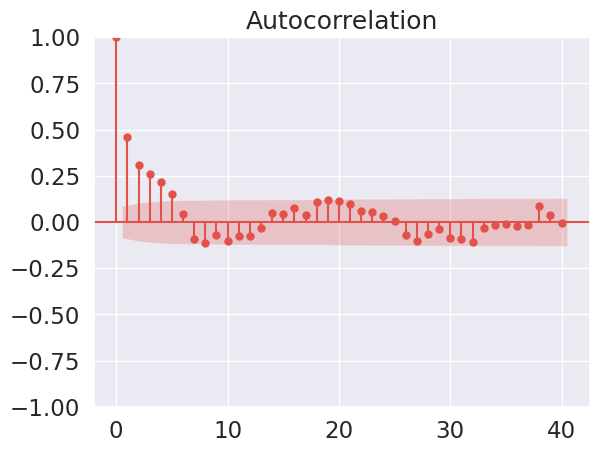

In [80]:
import statsmodels.api as sm
##autocorrelation
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()



The results show signs of autocorelation since there are spikes outside the red confidence interval region. This could be a factor of seasonality in the data.

# Homoscedasticity

This assumes homoscedasticity, which is the same variance within our error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.

<b>Why it can happen</b>: Our model may be giving too much weight to a subset of the data, particularly where the error variance was the largest.

<b>What it will affect</b>: Significance tests for coefficients due to the standard errors being biased. Additionally, the confidence intervals will be either too wide or too narrow.

<b>How to detect it</b>: Plot the residuals and see if the variance appears to be uniform.

<b>How to fix it</b>: Heteroscedasticity (can you tell I like the scedasticity words?) can be solved either by using weighted least squares regression instead of the standard OLS or transforming either the dependent or highly skewed variables. Performing a log transformation on the dependent variable is not a bad place to start.

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


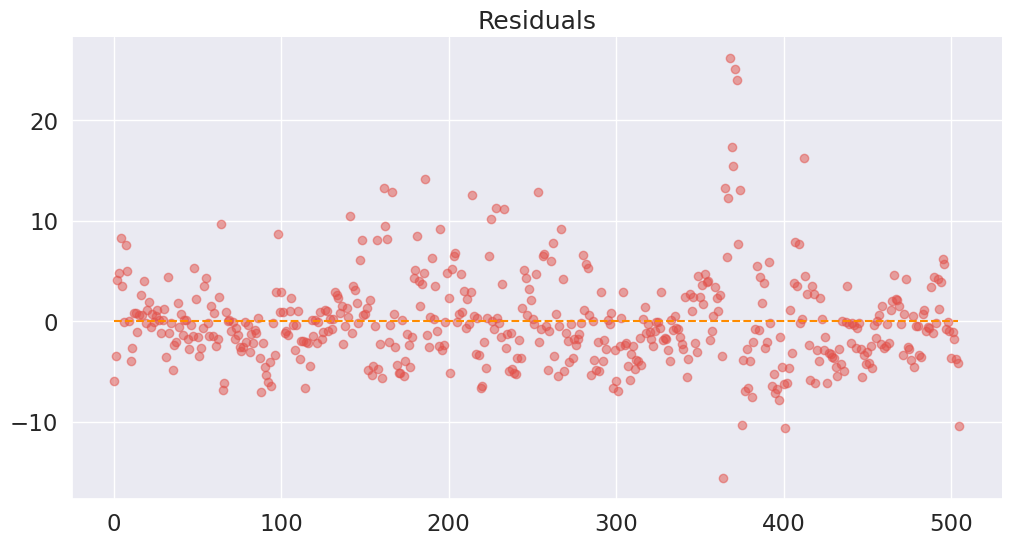

In [96]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  
homoscedasticity_assumption(boston_model,x,y)

We can’t see a fully uniform variance across our residuals, so this is potentially problematic. However, we know from our other tests that our model has several issues and is under predicting in many cases.

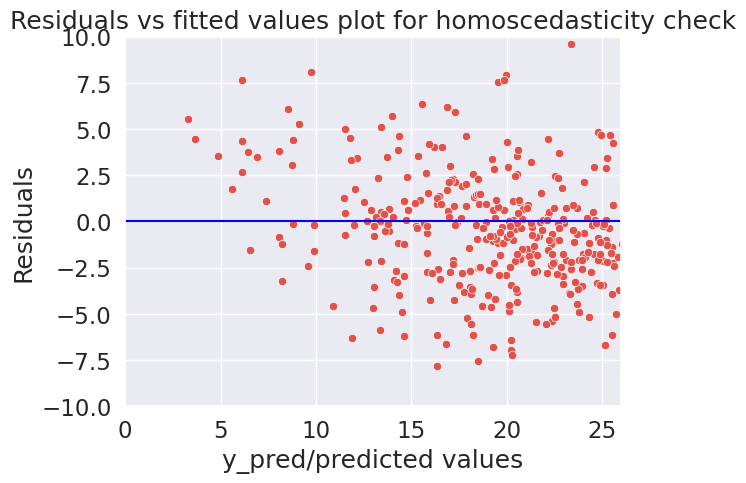

In [102]:
p = sns.scatterplot(x=y_pred,y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot(x=[0,36],y=[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

